<a href="https://colab.research.google.com/github/ehpub/KFQ_DL_2023-/blob/main/2023_kfq_%EB%94%A5%EB%9F%AC%EB%8B%9D_VAE_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EC%83%9D%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고 교재: https://www.gilbut.co.kr/book/view?bookcode=BN003496

In [1]:
from tensorflow import keras
from keras import layers

In [2]:
latent_dim = 2

In [3]:
encoder_inputs = keras.Input(shape=(28,28,1))
x = layers.Conv2D(32,3,activation='relu',strides=2,padding='same')(encoder_inputs)
x = layers.Conv2D(64,3,activation='relu',strides=2,padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16,activation='relu')(x)
z_mean = layers.Dense(latent_dim,name="z_mean")(x)
z_log_var = layers.Dense(latent_dim,name="z_log_var")(x)
encoder = keras.Model(encoder_inputs,[z_mean,z_log_var],name='encoder')

In [4]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [5]:
import tensorflow as tf

In [6]:
class Sampler(layers.Layer):
  def call(self,z_mean,z_log_var):
    batch_size = tf.shape(z_mean)[0]
    z_size = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch_size,z_size))
    return z_mean + tf.exp(0.5*z_log_var)*epsilon

In [7]:
lentent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7*7*64,activation='relu')(lentent_inputs)
x = layers.Reshape((7,7,64))(x)
x = layers.Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(x)
x = layers.Conv2DTranspose(32,3,activation='relu',strides=2,padding='same')(x)
decoder_outputs = layers.Conv2D(1,3,activation='sigmoid',padding='same')(x)
decoder = keras.Model(lentent_inputs,decoder_outputs,name='decoder')

In [8]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [10]:
import numpy as np

In [11]:
(x_train,_),(x_test,_) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [17]:
mnist_digits = np.concatenate([x_train,x_test],axis=0)

In [18]:
mnist_digits = np.expand_dims(mnist_digits,-1).astype('float32')/255

In [19]:
from keras.engine.training import optimizer
vae = VAE(encoder,decoder)
vae.compile(optimizer="adam",run_eagerly=True)
vae.fit(mnist_digits,epochs=30,batch_size=128)

Epoch 1/30


547/547 [==============================] - 31s 50ms/step - total_loss: 210.7671 - reconstruction_loss: 208.4147 - kl_loss: 2.3521
Epoch 2/30
547/547 [==============================] - 29s 52ms/step - total_loss: 171.1211 - reconstruction_loss: 167.2824 - kl_loss: 3.8386
Epoch 3/30
547/547 [==============================] - 27s 49ms/step - total_loss: 165.5139 - reconstruction_loss: 161.6870 - kl_loss: 3.8269
Epoch 4/30
547/547 [==============================] - 27s 49ms/step - total_loss: 162.3265 - reconstruction_loss: 158.4201 - kl_loss: 3.9064
Epoch 5/30
547/547 [==============================] - 27s 49ms/step - total_loss: 160.1683 - reconstruction_loss: 156.2081 - kl_loss: 3.9600
Epoch 6/30
547/547 [==============================] - 26s 48ms/step - total_loss: 158.4548 - reconstruction_loss: 154.4568 - kl_loss: 3.9979
Epoch 7/30
547/547 [==============================] - 27s 50ms/step - total_loss: 157.1025 - reconstruction_loss: 153.0771 - kl_loss: 4.0255
Epoch 8/30
547/547 [====

In [20]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 17ms/step


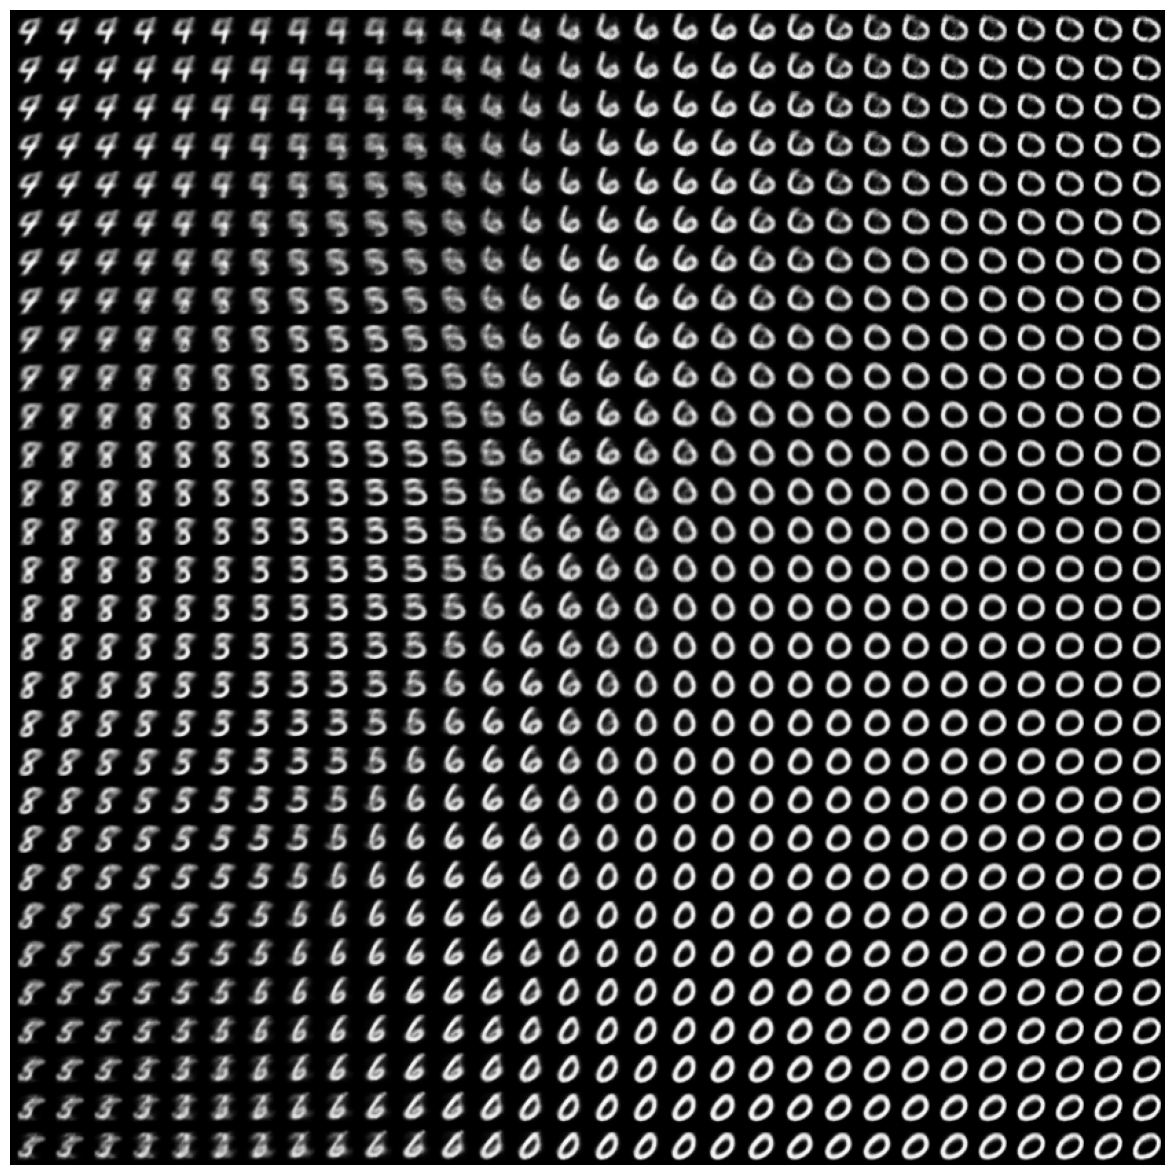

In [21]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")
plt.show()